### Some Imports

In [1]:
# Makes code autoreload when changed!
%load_ext autoreload
%autoreload 2

# imports
import torch
from model import MobileFaceNet
from mtcnn import MTCNN
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms as trans
import numpy as np
import cv2
import os
import json

/home/yair/miniconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Load models

In [2]:
# Load MTCNN
detector = MTCNN()

# Loading a pretrained MobileNet for faces, trained on 100 celebs
recognizer = MobileFaceNet(classes_count=100) # Load the architecture

recognizer_state_dict = torch.load('pretrained/mobilenet_celebs_100.pth', map_location='cpu') # Load the weights
recognizer.load_state_dict(recognizer_state_dict) 
recognizer.eval()

# Load model class names
with open('pretrained/classes_celebs_100.json','r') as f:
    classes = json.load(f)

recognizer_test_transform = trans.Compose(
    [trans.ToTensor(), trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

cpu


/tmp/ipykernel_622528/2791184413.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recognizer_state_dict = torch.load('pretrained/mobilenet_celebs_100.pth', map_location='

### Helper functions

In [3]:
# The input transformation
from typing import Optional, Tuple


# Bounding box draw
def draw_box_name(
    bbox,
    frame: np.ndarray,
    name: Optional[str] = None,
    color: Tuple[int, int, int] = (0, 0, 255),
) -> np.ndarray:
    frame = cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 4)
    if name:
        frame = cv2.putText(
            frame, name, (bbox[0], bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0)
        )
    return frame

### Load Input Image

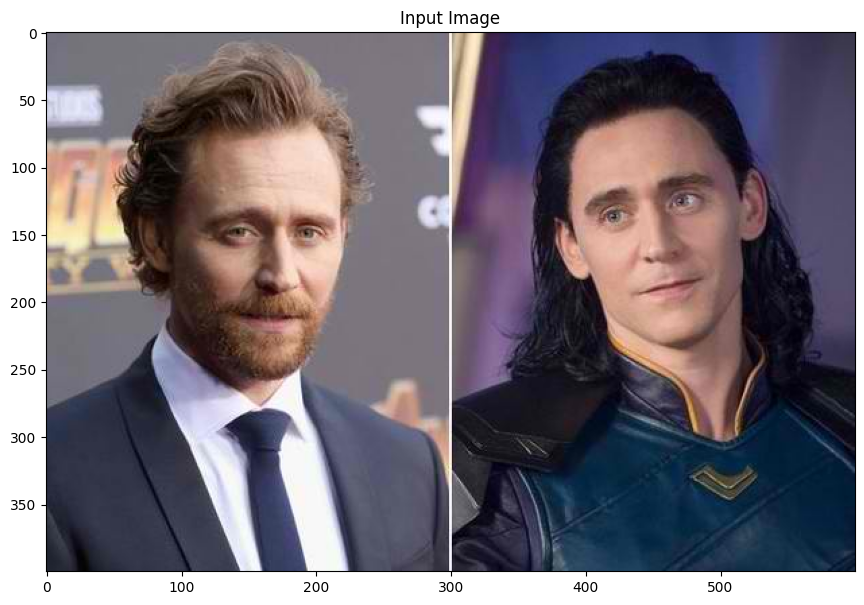

In [4]:
im_path = 'tom.jpg'
im_name = os.path.basename(im_path)
image = Image.open(im_path).convert('RGB')

fig = plt.figure(figsize=(13,7))
plt.imshow(image)
plt.title('Input Image')
plt.show()

### Run detection

To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


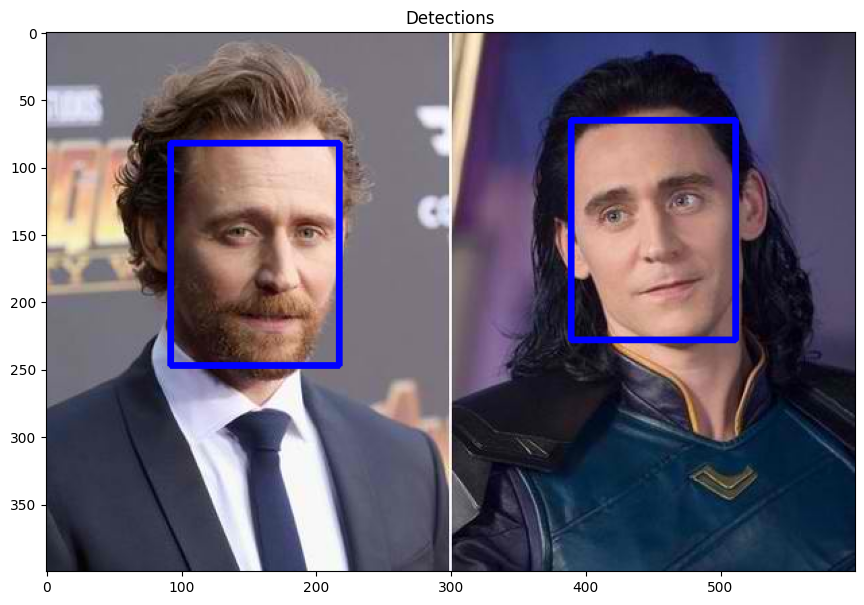

In [6]:
# Run detection on image
bboxes_and_scores, faces = detector.align_multi(image, limit=None, min_face_size=10)

# Draw on image
bboxes = bboxes_and_scores[:, :4].astype(int)
res_img = np.array(image)
for i, bbox in enumerate(bboxes):
    res_img = draw_box_name(bbox, res_img)

fig = plt.figure(figsize=(13, 7))
plt.imshow(res_img)
plt.title("Detections")
plt.show()

### Run recognition

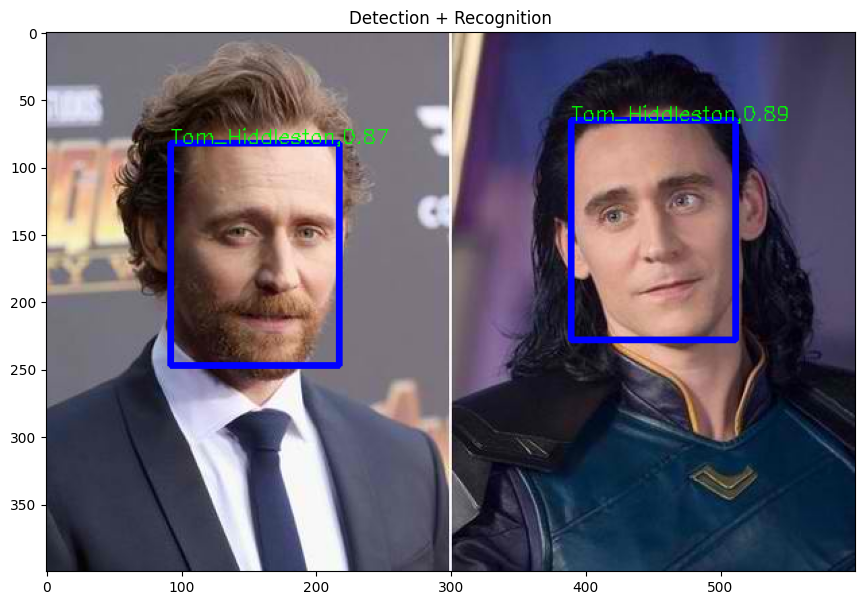

In [8]:
res_img = np.array(image)
# Run recognition on all images
labels = []
for i in range(len(faces)): 
    vec_test = recognizer(recognizer_test_transform(faces[i]).unsqueeze(0)) # Get predictions
    vec_test = torch.nn.Softmax(dim=1)(vec_test) # Apply softmax to get probabilities
    vec_test = vec_test.detach().numpy()[0] # Transform to numpy array
    best_ind = np.argmax(vec_test) # Get best prediction
    res_img = draw_box_name(bboxes[i],res_img,name='{},{:.2f}'.format(classes[best_ind],vec_test[best_ind]))

fig = plt.figure(figsize=(13,7))
plt.imshow(res_img)
plt.title('Detection + Recognition')
plt.show()
